# S&P 500 High Volatility Prediction

This notebook implements an LSTM-based model to predict high volatility days in the S&P 500 index.

## Objective
Predict whether the next day will have **high volatility** (above median) or **low volatility** (below median), where volatility is defined as the absolute value of the daily price change.

## Approach
- **Features**: Uses only the 5 original OHLCV features (Open, High, Low, Close, Volume)
- **Model**: LSTM neural network with hyperparameter tuning
- **Target**: Binary classification (1 = high volatility, 0 = low volatility)
- **Evaluation**: Accuracy, Precision, Recall, F1-Score, ROC-AUC


In [1]:
# Cell 1: Imports and Configuration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid' if 'seaborn-v0_8-darkgrid' in plt.style.available else 'ggplot')
sns.set_palette("husl")

# ===== CONFIGURATION =====
DATA_PATH = "data/sp500_2015_2025.csv"

# Model hyperparameters (will be tuned)
WINDOW_SIZE = 30  # Number of days to look back
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001

# Date splits
TRAIN_END = "2022-12-31"
VAL_END = "2023-12-31"
TEST_END = "2025-01-01"

# Model architecture parameters (will be tuned)
LSTM_UNITS_1 = 50
LSTM_UNITS_2 = 100
DROPOUT_RATE = 0.2
DENSE_UNITS = 32

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
import random
random.seed(RANDOM_SEED)

# GPU check
print(f"TensorFlow version: {tf.__version__}")
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"GPU Available: {len(gpu_devices) > 0}")
if gpu_devices:
    print(f"Using GPU: {gpu_devices[0]}")
else:
    print("Using CPU for training")

print("\n✓ Configuration loaded successfully!")


TensorFlow version: 2.10.1
GPU Available: True
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

✓ Configuration loaded successfully!


In [2]:
# Cell 2: Load and Prepare Data

print(f"Loading data from: {DATA_PATH}")

# Load CSV (skip metadata row)
df = pd.read_csv(DATA_PATH, skiprows=[1])

# Convert Date to datetime and set as index
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
elif df.index.dtype == 'object':
    df.index = pd.to_datetime(df.index)

# Sort by date
df.sort_index(inplace=True)

# Convert OHLCV columns to numeric
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle missing values
df = df.ffill().dropna()

print(f"\n✓ Data loaded successfully!")
print(f"  Shape: {df.shape}")
print(f"  Date range: {df.index.min().date()} to {df.index.max().date()}")
print(f"  Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData statistics:")
print(df.describe())


Loading data from: data/sp500_2015_2025.csv

✓ Data loaded successfully!
  Shape: (2516, 5)
  Date range: 2015-01-02 to 2024-12-31
  Columns: ['Close', 'High', 'Low', 'Open', 'Volume']

First few rows:
                  Close         High          Low         Open      Volume
Date                                                                      
2015-01-02  2058.199951  2072.360107  2046.040039  2058.899902  2708700000
2015-01-05  2020.579956  2054.439941  2017.339966  2054.439941  3799120000
2015-01-06  2002.609985  2030.250000  1992.439941  2022.150024  4460110000
2015-01-07  2025.900024  2029.609985  2005.550049  2005.550049  3805480000
2015-01-08  2062.139893  2064.080078  2030.609985  2030.609985  3934010000

Data statistics:
             Close         High          Low         Open        Volume
count  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03
mean   3356.124980  3373.453029  3336.472451  3355.659257  4.005547e+09
std    1083.898653  1089.145872  1078.1

VOLATILITY TARGET CREATION

Volatility threshold (median): 0.004830 (0.4830%)

Target distribution:
  Low Volatility (0):  1257 (50.00%)
  High Volatility (1): 1257 (50.00%)

Volatility statistics:
  Mean:   0.007336 (0.7336%)
  Median: 0.004830 (0.4830%)
  Std:    0.008628 (0.8628%)
  Min:    0.000000 (0.0000%)
  Max:    0.136158 (13.6158%)


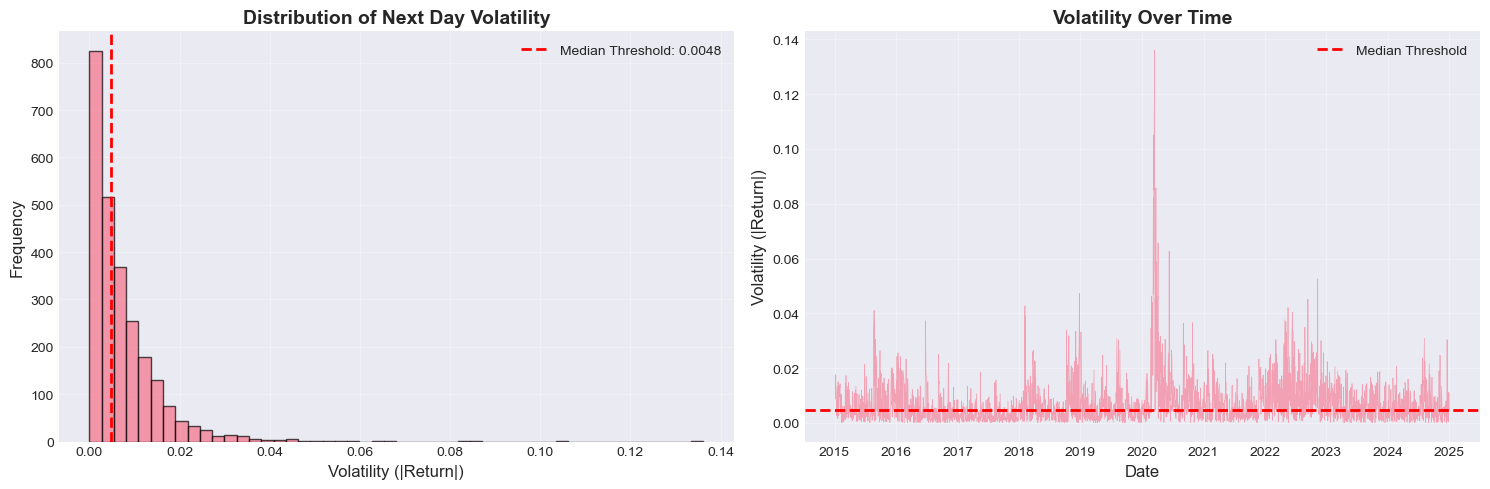


✓ Target created successfully!


In [5]:
# Cell 3: Create Volatility Target

# Calculate next day's volatility (absolute value of price change)
next_return = df['Close'].pct_change(-1).shift(1)  # Next day's return
next_volatility = next_return.abs()  # Absolute value = volatility

# Use median as threshold for high/low volatility
vol_threshold = next_volatility.median()
df['Next_Volatility'] = next_volatility
df['Target'] = (next_volatility > vol_threshold).astype(int)

# Drop rows with NaN target (last row)
df = df.dropna()

print("="*60)
print("VOLATILITY TARGET CREATION")
print("="*60)
print(f"\nVolatility threshold (median): {vol_threshold:.6f} ({vol_threshold*100:.4f}%)")
print(f"\nTarget distribution:")
target_counts = df['Target'].value_counts()
print(f"  Low Volatility (0):  {target_counts.get(0, 0):4d} ({target_counts.get(0, 0)/len(df)*100:.2f}%)")
print(f"  High Volatility (1): {target_counts.get(1, 0):4d} ({target_counts.get(1, 0)/len(df)*100:.2f}%)")

print(f"\nVolatility statistics:")
print(f"  Mean:   {df['Next_Volatility'].mean():.6f} ({df['Next_Volatility'].mean()*100:.4f}%)")
print(f"  Median: {df['Next_Volatility'].median():.6f} ({df['Next_Volatility'].median()*100:.4f}%)")
print(f"  Std:    {df['Next_Volatility'].std():.6f} ({df['Next_Volatility'].std()*100:.4f}%)")
print(f"  Min:    {df['Next_Volatility'].min():.6f} ({df['Next_Volatility'].min()*100:.4f}%)")
print(f"  Max:    {df['Next_Volatility'].max():.6f} ({df['Next_Volatility'].max()*100:.4f}%)")

# Visualize volatility distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of volatility (use df column which is aligned after dropna)
axes[0].hist(df['Next_Volatility'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(vol_threshold, color='red', linestyle='--', linewidth=2, label=f'Median Threshold: {vol_threshold:.4f}')
axes[0].set_xlabel('Volatility (|Return|)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Next Day Volatility', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time series of volatility (use df column which is aligned with df.index)
axes[1].plot(df.index, df['Next_Volatility'], alpha=0.6, linewidth=0.5)
axes[1].axhline(vol_threshold, color='red', linestyle='--', linewidth=2, label=f'Median Threshold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Volatility (|Return|)', fontsize=12)
axes[1].set_title('Volatility Over Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/volatility_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Target created successfully!")


In [6]:
# Cell 4: Prepare Features and Split Data

# Use only the 5 original OHLCV features
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
X = df[feature_columns].copy()
y = df['Target'].copy()

print(f"Features used: {feature_columns}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split by date ranges
train_data = X[X.index <= TRAIN_END].copy()
train_labels = y[y.index <= TRAIN_END].copy()

val_data = X[(X.index > TRAIN_END) & (X.index <= VAL_END)].copy()
val_labels = y[(y.index > TRAIN_END) & (y.index <= VAL_END)].copy()

test_data = X[(X.index > VAL_END) & (X.index <= TEST_END)].copy()
test_labels = y[(y.index > VAL_END) & (y.index <= TEST_END)].copy()

print(f"\n" + "="*60)
print("DATA SPLITS")
print("="*60)
print(f"Train set:    {len(train_data):4d} samples ({train_data.index.min().date()} to {train_data.index.max().date()})")
print(f"Validation:   {len(val_data):4d} samples ({val_data.index.min().date()} to {val_data.index.max().date()})")
print(f"Test set:     {len(test_data):4d} samples ({test_data.index.min().date()} to {test_data.index.max().date()})")

# Check for data quality issues
print(f"\nData quality check...")
for name, data in [("Train", train_data), ("Validation", val_data), ("Test", test_data)]:
    has_inf = data.isin([np.inf, -np.inf]).any().any()
    has_nan = data.isna().any().any()
    if has_inf or has_nan:
        print(f"  ⚠️  {name} data has issues - cleaning...")
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        data.fillna(data.mean(), inplace=True)
    else:
        print(f"  ✓ {name} data is clean")

# Scale features (fit only on training data)
scaler = MinMaxScaler()
train_data_scaled = pd.DataFrame(
    scaler.fit_transform(train_data),
    columns=train_data.columns,
    index=train_data.index
)
val_data_scaled = pd.DataFrame(
    scaler.transform(val_data),
    columns=val_data.columns,
    index=val_data.index
)
test_data_scaled = pd.DataFrame(
    scaler.transform(test_data),
    columns=test_data.columns,
    index=test_data.index
)

print("\n✓ Data scaled using MinMaxScaler (fitted on training data only)")


Features used: ['Open', 'High', 'Low', 'Close', 'Volume']
X shape: (2514, 5)
y shape: (2514,)

DATA SPLITS
Train set:    2012 samples (2015-01-06 to 2022-12-30)
Validation:    250 samples (2023-01-03 to 2023-12-29)
Test set:      252 samples (2024-01-02 to 2024-12-31)

Data quality check...
  ✓ Train data is clean
  ✓ Validation data is clean
  ✓ Test data is clean

✓ Data scaled using MinMaxScaler (fitted on training data only)


In [7]:
# Cell 5: Create Sequences for LSTM

def create_sequences(features, labels, window_size):
    """
    Create sliding window sequences for LSTM input.
    
    Args:
        features: DataFrame or array of features
        labels: Series or array of labels
        window_size: Number of time steps to look back
    
    Returns:
        X: Array of shape (samples, window_size, n_features)
        y: Array of shape (samples,)
    """
    X, y = [], []
    
    # Convert to numpy if needed
    if isinstance(features, pd.DataFrame):
        features = features.values
    if isinstance(labels, pd.Series):
        labels = labels.values
    
    for i in range(window_size, len(features)):
        X.append(features[i-window_size:i])
        y.append(labels[i])
    
    return np.array(X), np.array(y)

# Create sequences for each split
X_train, y_train = create_sequences(train_data_scaled, train_labels, WINDOW_SIZE)
X_val, y_val = create_sequences(val_data_scaled, val_labels, WINDOW_SIZE)
X_test, y_test = create_sequences(test_data_scaled, test_labels, WINDOW_SIZE)

print("="*60)
print("SEQUENCE CREATION")
print("="*60)
print(f"Training sequences:   X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"Validation sequences: X_val.shape = {X_val.shape},   y_val.shape = {y_val.shape}")
print(f"Test sequences:       X_test.shape = {X_test.shape},   y_test.shape = {y_test.shape}")
print(f"\nSequence structure: (samples, {WINDOW_SIZE} days, {X_train.shape[2]} features)")
print(f"✓ Sequences created successfully!")


SEQUENCE CREATION
Training sequences:   X_train.shape = (1982, 30, 5), y_train.shape = (1982,)
Validation sequences: X_val.shape = (220, 30, 5),   y_val.shape = (220,)
Test sequences:       X_test.shape = (222, 30, 5),   y_test.shape = (222,)

Sequence structure: (samples, 30 days, 5 features)
✓ Sequences created successfully!


In [8]:
# Cell 6: Define Model Architecture

def build_lstm_model(lstm_units_1=50, lstm_units_2=100, dropout_rate=0.2, 
                     dense_units=32, learning_rate=0.001, input_shape=None):
    """
    Build LSTM model for binary classification.
    
    Args:
        lstm_units_1: Number of units in first LSTM layer
        lstm_units_2: Number of units in second LSTM layer
        dropout_rate: Dropout rate
        dense_units: Number of units in dense layer
        learning_rate: Learning rate for Adam optimizer
        input_shape: Shape of input (window_size, n_features)
    
    Returns:
        Compiled Keras model
    """
    model = Sequential([
        LSTM(lstm_units_1, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units_2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    
    return model

# Build initial model to show architecture
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(
    lstm_units_1=LSTM_UNITS_1,
    lstm_units_2=LSTM_UNITS_2,
    dropout_rate=DROPOUT_RATE,
    dense_units=DENSE_UNITS,
    learning_rate=LEARNING_RATE,
    input_shape=input_shape
)

print("="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model.summary()
print(f"\n✓ Model architecture defined")


MODEL ARCHITECTURE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 74,865
Trainable params

In [9]:
# Cell 7: Hyperparameter Tuning

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("="*60)
print("HYPERPARAMETER TUNING")
print("="*60)
print(f"Class weights: {class_weight_dict}")
print()

# Define hyperparameter grid (reduced for faster tuning)
param_grid = {
    'lstm_units_1': [50, 64],
    'lstm_units_2': [100, 128],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [64]  # Fixed to most common value
}

# Calculate total combinations
total_combinations = (len(param_grid['lstm_units_1']) * 
                     len(param_grid['lstm_units_2']) * 
                     len(param_grid['dropout_rate']) * 
                     len(param_grid['learning_rate']) * 
                     len(param_grid['batch_size']))

print(f"Testing {total_combinations} hyperparameter combinations...")
print("Each combination trains for up to 15 epochs with early stopping.\n")

# Store results
tuning_results = []
best_val_acc = 0
best_params = None
best_model = None

trial = 0
for lstm1 in param_grid['lstm_units_1']:
    for lstm2 in param_grid['lstm_units_2']:
        for dropout in param_grid['dropout_rate']:
            for lr in param_grid['learning_rate']:
                for bs in param_grid['batch_size']:
                    trial += 1
                    print(f"[{trial}/{total_combinations}] LSTM1={lstm1:2d}, LSTM2={lstm2:3d}, "
                          f"Dropout={dropout:.1f}, LR={lr:.4f}, BS={bs:2d}", end=" ... ")
                    
                    # Build model
                    model_trial = build_lstm_model(
                        lstm_units_1=lstm1,
                        lstm_units_2=lstm2,
                        dropout_rate=dropout,
                        dense_units=DENSE_UNITS,
                        learning_rate=lr,
                        input_shape=input_shape
                    )
                    
                    # Train with early stopping
                    early_stop = EarlyStopping(
                        monitor='val_accuracy',
                        patience=5,
                        restore_best_weights=True,
                        verbose=0
                    )
                    
                    history = model_trial.fit(
                        X_train, y_train,
                        batch_size=bs,
                        epochs=15,  # Reduced for faster tuning
                        validation_data=(X_val, y_val),
                        callbacks=[early_stop],
                        class_weight=class_weight_dict,
                        verbose=0
                    )
                    
                    # Get best validation accuracy
                    val_acc = max(history.history['val_accuracy'])
                    
                    tuning_results.append({
                        'lstm_units_1': lstm1,
                        'lstm_units_2': lstm2,
                        'dropout_rate': dropout,
                        'learning_rate': lr,
                        'batch_size': bs,
                        'val_accuracy': val_acc
                    })
                    
                    print(f"Val Acc: {val_acc:.4f}")
                    
                    # Track best model
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_params = {
                            'lstm_units_1': lstm1,
                            'lstm_units_2': lstm2,
                            'dropout_rate': dropout,
                            'learning_rate': lr,
                            'batch_size': bs
                        }
                        best_model = model_trial

# Display results
print("\n" + "="*60)
print("TUNING RESULTS SUMMARY")
print("="*60)
results_df = pd.DataFrame(tuning_results)
results_df = results_df.sort_values('val_accuracy', ascending=False)

print("\nAll configurations (sorted by validation accuracy):")
print(results_df.to_string(index=False))

print(f"\n{'='*60}")
print("BEST CONFIGURATION")
print("="*60)
print(f"  LSTM Units 1:    {best_params['lstm_units_1']}")
print(f"  LSTM Units 2:    {best_params['lstm_units_2']}")
print(f"  Dropout Rate:    {best_params['dropout_rate']}")
print(f"  Learning Rate:   {best_params['learning_rate']}")
print(f"  Batch Size:      {best_params['batch_size']}")
print(f"  Validation Acc:  {best_val_acc:.4f}")
print("="*60)

# Update global parameters
LSTM_UNITS_1 = best_params['lstm_units_1']
LSTM_UNITS_2 = best_params['lstm_units_2']
DROPOUT_RATE = best_params['dropout_rate']
LEARNING_RATE = best_params['learning_rate']
BATCH_SIZE = best_params['batch_size']
model = best_model

print("\n✓ Hyperparameter tuning complete!")


HYPERPARAMETER TUNING
Class weights: {0: 0.9969818913480886, 1: 1.0030364372469636}

Testing 16 hyperparameter combinations...
Each combination trains for up to 15 epochs with early stopping.

[1/16] LSTM1=50, LSTM2=100, Dropout=0.2, LR=0.0010, BS=64 ... Val Acc: 0.4955
[2/16] LSTM1=50, LSTM2=100, Dropout=0.2, LR=0.0005, BS=64 ... Val Acc: 0.4955
[3/16] LSTM1=50, LSTM2=100, Dropout=0.3, LR=0.0010, BS=64 ... Val Acc: 0.4955
[4/16] LSTM1=50, LSTM2=100, Dropout=0.3, LR=0.0005, BS=64 ... Val Acc: 0.4955
[5/16] LSTM1=50, LSTM2=128, Dropout=0.2, LR=0.0010, BS=64 ... Val Acc: 0.4955
[6/16] LSTM1=50, LSTM2=128, Dropout=0.2, LR=0.0005, BS=64 ... Val Acc: 0.4955
[7/16] LSTM1=50, LSTM2=128, Dropout=0.3, LR=0.0010, BS=64 ... Val Acc: 0.4955
[8/16] LSTM1=50, LSTM2=128, Dropout=0.3, LR=0.0005, BS=64 ... Val Acc: 0.4955
[9/16] LSTM1=64, LSTM2=100, Dropout=0.2, LR=0.0010, BS=64 ... Val Acc: 0.4955
[10/16] LSTM1=64, LSTM2=100, Dropout=0.2, LR=0.0005, BS=64 ... Val Acc: 0.4955
[11/16] LSTM1=64, LSTM2=10

Using best model from hyperparameter tuning

TRAINING SETUP
  Class 0 (Low Volatility):  994 (50.15%)
  Class 1 (High Volatility):  988 (49.85%)

Class weights: {0: 0.9969818913480886, 1: 1.0030364372469636}
Training for up to 100 epochs with early stopping...

TRAINING
Epoch 1/100
30/31 [============================>.] - ETA: 0s - loss: 0.6835 - accuracy: 0.5693
Epoch 1: val_accuracy improved from -inf to 0.49545, saving model to models\sp500_volatility_lstm_best.h5
31/31 [==============================] - 1s 26ms/step - loss: 0.6839 - accuracy: 0.5701 - val_loss: 0.7614 - val_accuracy: 0.4955
Epoch 2/100
30/31 [============================>.] - ETA: 0s - loss: 0.6785 - accuracy: 0.5880
Epoch 2: val_accuracy did not improve from 0.49545
31/31 [==============================] - 1s 23ms/step - loss: 0.6782 - accuracy: 0.5878 - val_loss: 0.7542 - val_accuracy: 0.4955
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.6044
Epoch 3: val_accuracy did n

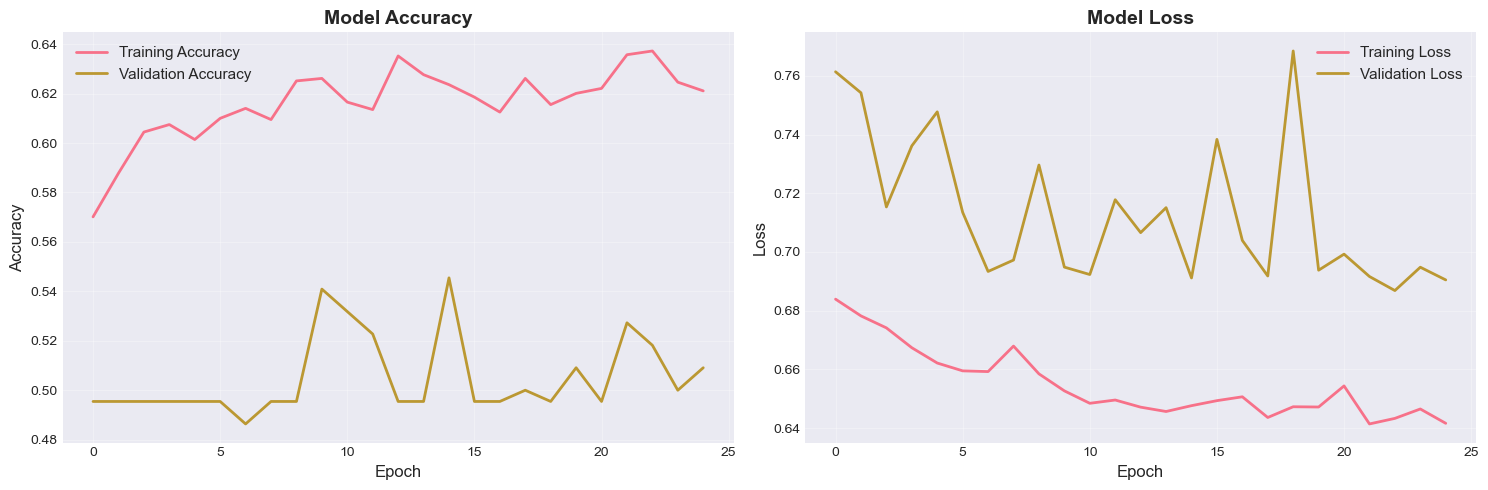


✓ Training completed!
  Best training accuracy:   0.6372
  Best validation accuracy: 0.5455
  Training epochs:         25


In [10]:
# Cell 8: Final Model Training

# Rebuild model with best parameters (or use from tuning)
if 'best_model' in locals() and best_model is not None:
    model = best_model
    print("Using best model from hyperparameter tuning")
else:
    model = build_lstm_model(
        lstm_units_1=LSTM_UNITS_1,
        lstm_units_2=LSTM_UNITS_2,
        dropout_rate=DROPOUT_RATE,
        dense_units=DENSE_UNITS,
        learning_rate=LEARNING_RATE,
        input_shape=input_shape
    )
    print("Using model with configured parameters")

# Setup callbacks
os.makedirs('models', exist_ok=True)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'models/sp500_volatility_lstm_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Class distribution
print("\n" + "="*60)
print("TRAINING SETUP")
print("="*60)
unique, counts = np.unique(y_train, return_counts=True)
for val, count in zip(unique, counts):
    label = 'High Volatility' if val == 1 else 'Low Volatility'
    print(f"  Class {val} ({label}): {count:4d} ({count/len(y_train)*100:.2f}%)")

print(f"\nClass weights: {class_weight_dict}")
print(f"Training for up to {EPOCHS} epochs with early stopping...")

# Train the model
print("\n" + "="*60)
print("TRAINING")
print("="*60)
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Training completed!")
print(f"  Best training accuracy:   {max(history.history['accuracy']):.4f}")
print(f"  Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"  Training epochs:         {len(history.history['accuracy'])}")


TEST SET EVALUATION
Accuracy:  0.5225
Precision: 0.0000
Recall:    0.0000
F1-Score: 0.0000
ROC-AUC:   0.5179

Classification Report:
                 precision    recall  f1-score   support

 Low Volatility       0.52      1.00      0.69       116
High Volatility       0.00      0.00      0.00       106

       accuracy                           0.52       222
      macro avg       0.26      0.50      0.34       222
   weighted avg       0.27      0.52      0.36       222



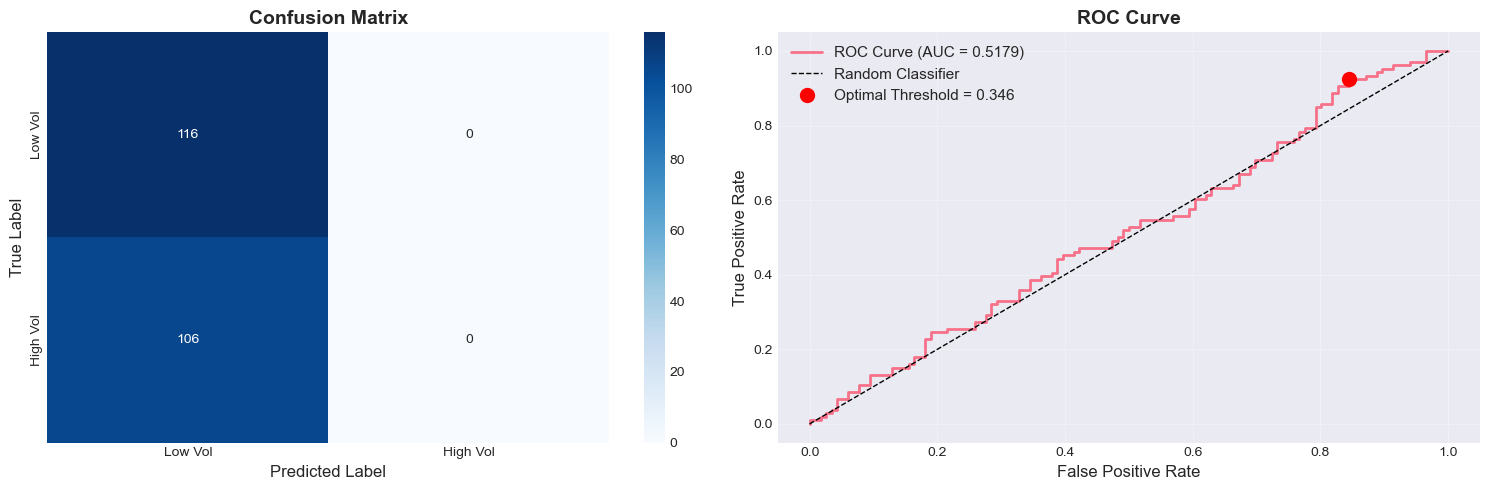


PREDICTION ANALYSIS
Predicted probability range: [0.3232, 0.4944]
Predicted probability mean:  0.3961

Prediction distribution (threshold=0.5):
  Low Volatility (0):   222 (100.00%)
  High Volatility (1):    0 (0.00%)

Actual distribution:
  Low Volatility (0):   116 (52.25%)
  High Volatility (1):  106 (47.75%)

✓ Evaluation complete!


In [11]:
# Cell 9: Model Evaluation on Test Set

# Make predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print results
print("="*60)
print("TEST SET EVALUATION")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("="*60)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low Volatility', 'High Volatility']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Low Vol', 'High Vol'], 
            yticklabels=['Low Vol', 'High Vol'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]

axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
            label=f'Optimal Threshold = {optimal_threshold:.3f}')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('models/test_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Prediction distribution
print("\n" + "="*60)
print("PREDICTION ANALYSIS")
print("="*60)
print(f"Predicted probability range: [{y_pred_proba.min():.4f}, {y_pred_proba.max():.4f}]")
print(f"Predicted probability mean:  {y_pred_proba.mean():.4f}")

pred_counts = pd.Series(y_pred).value_counts()
print(f"\nPrediction distribution (threshold=0.5):")
print(f"  Low Volatility (0):  {pred_counts.get(0, 0):4d} ({pred_counts.get(0, 0)/len(y_pred)*100:.2f}%)")
print(f"  High Volatility (1): {pred_counts.get(1, 0):4d} ({pred_counts.get(1, 0)/len(y_pred)*100:.2f}%)")

actual_counts = pd.Series(y_test).value_counts()
print(f"\nActual distribution:")
print(f"  Low Volatility (0):  {actual_counts.get(0, 0):4d} ({actual_counts.get(0, 0)/len(y_test)*100:.2f}%)")
print(f"  High Volatility (1): {actual_counts.get(1, 0):4d} ({actual_counts.get(1, 0)/len(y_test)*100:.2f}%)")

print(f"\n✓ Evaluation complete!")


In [ ]:
# Cell 10: Save Model and Artifacts

os.makedirs('models', exist_ok=True)

# Save full model
model_full_path = 'models/sp500_volatility_lstm_full.h5'
model.save(model_full_path)
print(f"✓ Full model saved to: {model_full_path}")

# Save model weights
model_weights_path = 'models/sp500_volatility_lstm_weights.h5'
model.save_weights(model_weights_path)
print(f"✓ Model weights saved to: {model_weights_path}")

# Save scaler
scaler_path = 'models/sp500_volatility_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved to: {scaler_path}")

# Save feature info and configuration
feature_info = {
    'feature_columns': feature_columns,
    'window_size': WINDOW_SIZE,
    'input_shape': input_shape,
    'best_hyperparameters': {
        'lstm_units_1': LSTM_UNITS_1,
        'lstm_units_2': LSTM_UNITS_2,
        'dropout_rate': DROPOUT_RATE,
        'dense_units': DENSE_UNITS,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE
    },
    'volatility_threshold': float(vol_threshold),
    'test_metrics': {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc)
    }
}
feature_info_path = 'models/volatility_model_info.pkl'
with open(feature_info_path, 'wb') as f:
    pickle.dump(feature_info, f)
print(f"✓ Model info saved to: {feature_info_path}")

print("\n" + "="*60)
print("MODEL SAVING COMPLETE")
print("="*60)
print("\nSaved files:")
print(f"  1. {model_full_path}")
print(f"  2. {model_weights_path}")
print(f"  3. {scaler_path}")
print(f"  4. {feature_info_path}")
print("\n✓ All artifacts saved successfully!")


In [ ]:
# Cell 11: Inference Example

print("="*60)
print("INFERENCE EXAMPLE")
print("="*60)

# Load saved model
print("\nLoading saved model...")
loaded_model = tf.keras.models.load_model('models/sp500_volatility_lstm_full.h5')
print("✓ Model loaded")

# Load scaler
print("Loading scaler...")
with open('models/sp500_volatility_scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)
print("✓ Scaler loaded")

# Load model info
print("Loading model info...")
with open('models/volatility_model_info.pkl', 'rb') as f:
    loaded_info = pickle.load(f)
print("✓ Model info loaded")

# Example: Use last window from test set
print(f"\nUsing last {WINDOW_SIZE} days from test set as example input...")
example_window = X_test[-1:].copy()  # Shape: (1, window_size, n_features)

# Make prediction
prediction_proba = loaded_model.predict(example_window, verbose=0)[0][0]
prediction = 1 if prediction_proba > 0.5 else 0

print(f"\nInput shape: {example_window.shape}")
print(f"Predicted probability (high volatility): {prediction_proba:.4f}")
print(f"Predicted class: {'High Volatility' if prediction == 1 else 'Low Volatility'}")

# Show actual vs predicted
actual_label = y_test[-1]
actual_volatility = df.loc[test_data.index[-1], 'Next_Volatility']
print(f"\nActual volatility: {actual_volatility:.6f} ({actual_volatility*100:.4f}%)")
print(f"Actual class: {'High Volatility' if actual_label == 1 else 'Low Volatility'}")
print(f"Prediction: {'✓ CORRECT' if prediction == actual_label else '✗ INCORRECT'}")

print("\n" + "="*60)
print("USAGE INSTRUCTIONS")
print("="*60)
print("""
To use this model on new data:

1. Load the model:
   model = tf.keras.models.load_model('models/sp500_volatility_lstm_full.h5')

2. Load the scaler:
   scaler = pickle.load(open('models/sp500_volatility_scaler.pkl', 'rb'))

3. Prepare your data:
   - Extract last 30 days of OHLCV data (Open, High, Low, Close, Volume)
   - Ensure data is in same format as training data

4. Scale the data:
   scaled_data = scaler.transform(your_data)

5. Create sequence:
   sequence = scaled_data[-30:].reshape(1, 30, 5)

6. Make prediction:
   prob = model.predict(sequence)[0][0]
   prediction = 'High Volatility' if prob > 0.5 else 'Low Volatility'
""")
print("="*60)
